## Problem 21

In [1]:
import numpy as np

In [2]:
forecast = [29, 31, 27, 30, 34]
bootstrap_samples = [
    [29, 27, 31, 29, 31],
    [31, 30, 30, 27, 27],
    [27, 31, 29, 27, 34],
    [30, 27, 27, 27, 34],
    [29, 27, 29, 31, 27],
    [27, 27, 31, 29, 30],
    [29, 30, 27, 29, 30],
    [34, 29, 30, 34, 27],
    [31, 30, 29, 29, 34],
    [34, 30, 30, 31, 34]
]

In [9]:
# Compute 80% empirical confidence intervals (CI) for the mean and median temperature

# Mean
mean = np.mean(bootstrap_samples, axis=1)
mean.sort()
print("Means: ", mean)
# Mean of means
mean_of_means = np.mean(mean)
print("Mean of means: ", mean_of_means)

# Median
median = np.median(bootstrap_samples, axis=1)
median.sort()
print("Medians: ", median)

# 80% CI for mean
print("80% CI for mean: ", mean[1], " - ", mean[8])

# 80% CI for median
print("80% CI for median: ", median[1], " - ", median[8])

Means:  [28.6 28.8 29.  29.  29.  29.4 29.6 30.6 30.8 31.8]
Mean of means:  29.660000000000004
Medians:  [27. 29. 29. 29. 29. 29. 30. 30. 30. 31.]
80% CI for mean:  28.8  -  30.8
80% CI for median:  29.0  -  30.0


## Problem 22

In [13]:
# load mtcars dataset
import pandas as pd
mtcars = pd.read_csv("mtcars.csv", delimiter="\t")
mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [35]:
# Plot displacement vs. horsepower
import plotly.express as px
fig = px.scatter(mtcars, x="disp", y="hp", trendline="ols")
fig.show()

results = px.get_trendline_results(fig).iloc[0]["px_fit_results"]
results_sum = results.summary()
print(results_sum)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     50.13
Date:                Wed, 14 Jun 2023   Prob (F-statistic):           7.14e-08
Time:                        12:09:19   Log-Likelihood:                -164.47
No. Observations:                  32   AIC:                             332.9
Df Residuals:                      30   BIC:                             335.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.7345     16.129      2.836      0.0

In [39]:
import statsmodels.api as sm

def ransac(data, num_iter, min_cons, max_dist):
    """
    Performs RANSAC algorithm on data

    :param data: data to be fitted
    :param num_iter: number of iterations
    :param min_cons: minimum number of points to fit
    :param max_dist: maximum distance from line to be considered an inlier
    :return: best model parameters
    """
    # initialize best model parameters
    best_model = None
    best_cons = 0
    best_inliers = None

    for i in range(num_iter):
        # select random points
        points = data.sample(min_cons)

        # fit model to selected points
        model = sm.OLS(points["hp"], sm.add_constant(points["disp"])).fit()

        # compute distances from line
        distances = np.abs(data["hp"] - (model.params[0] + model.params[1] * data["disp"]))

        # find inliers
        inliers = data[distances < max_dist]

        # check if current model is better than best model
        if len(inliers) > best_cons:
            best_model = model
            best_cons = len(inliers)
            best_inliers = inliers

    return best_model, best_inliers

In [72]:
num_iter = [50, 100, 500, 1000]
min_cons = [10, 15, 20]
# use 80th percentile of residuals as threshold
max_dist = np.percentile(results.resid, 80)

# Run RANSAC algorithm
models = []
inliers = []
params = [] # meaning num_iter and min_cons
for i in num_iter:
    for j in min_cons:
        model, inlier = ransac(mtcars, i, j, max_dist)
        models.append(model)
        inliers.append(inlier)
        params.append((i, j))


In [73]:
# get numeric indices of residuals
resid_idx = models[0].resid.index.values

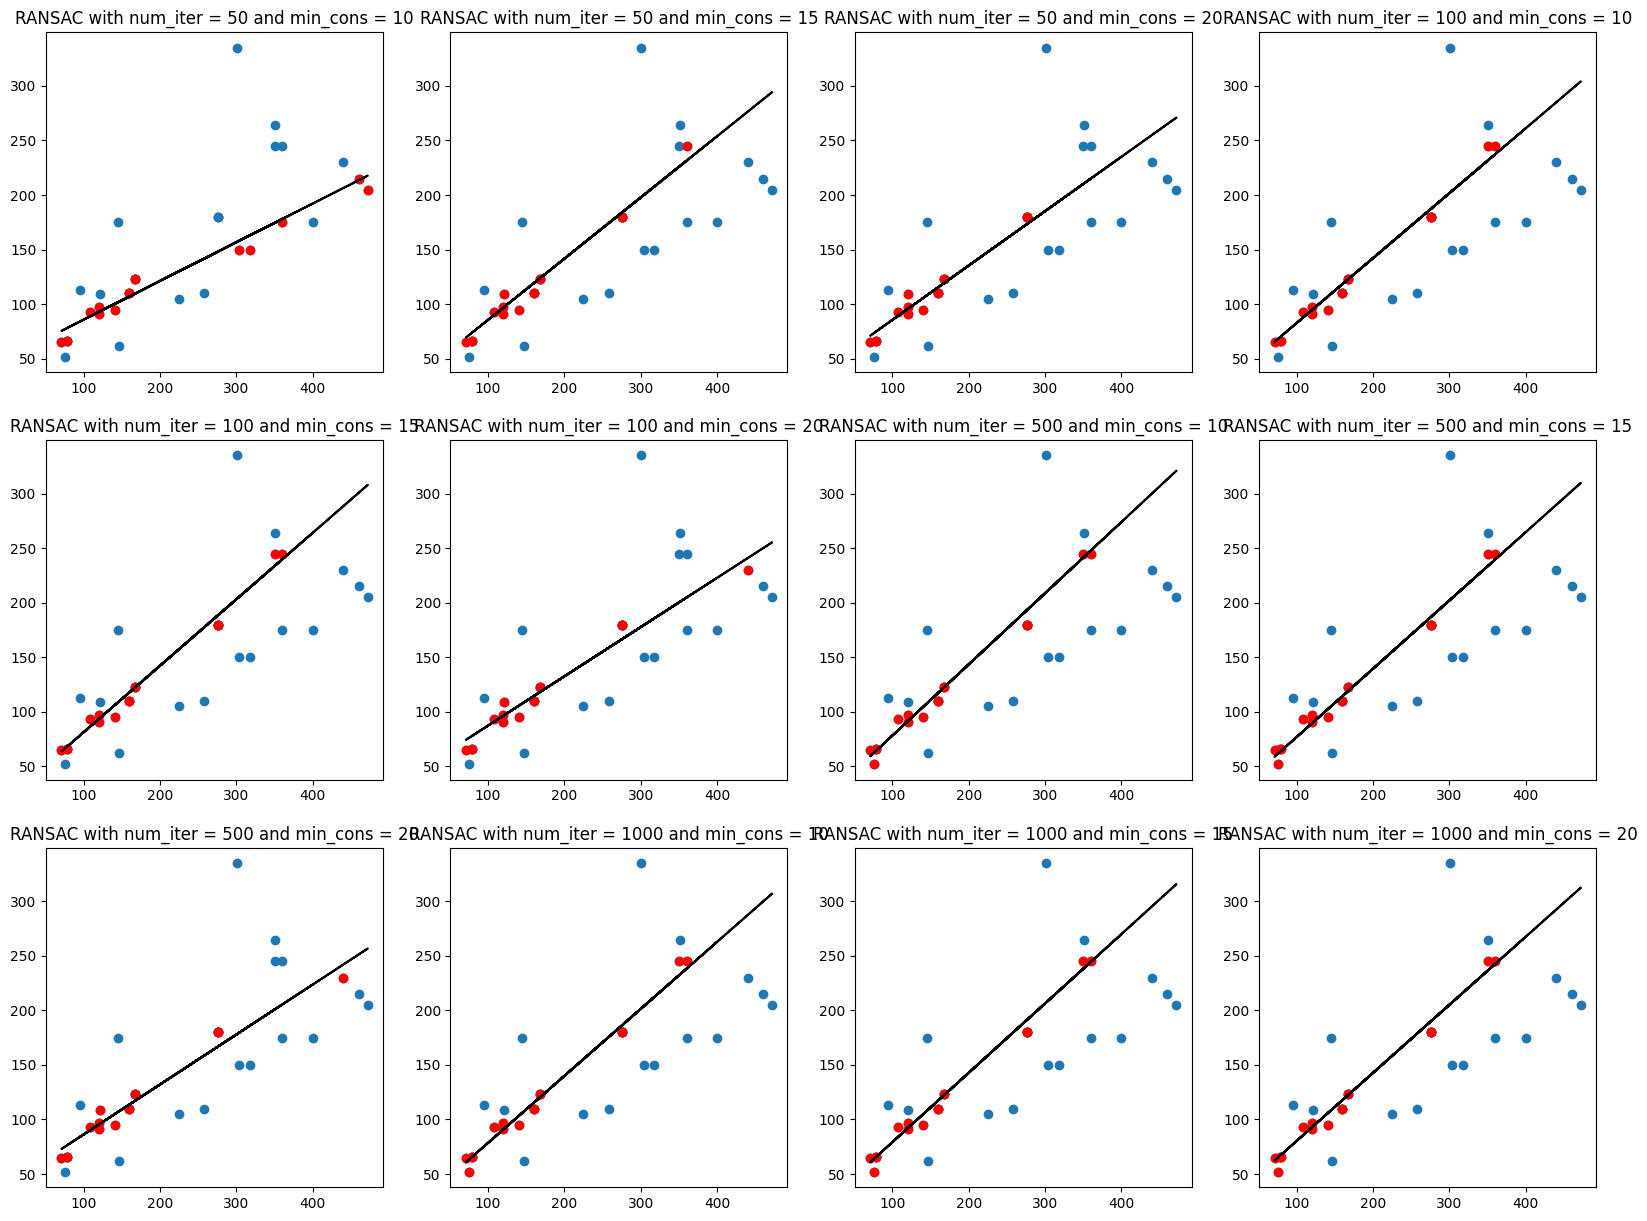

In [74]:
# plot all Ransac models with inliers as subplots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
axs = axs.ravel()
for i, model in enumerate(models):
    axs[i].scatter(mtcars["disp"], mtcars["hp"])
    axs[i].scatter(inliers[i]["disp"], inliers[i]["hp"], c="red")
    axs[i].plot(mtcars["disp"], model.params[0] + model.params[1] * mtcars["disp"], c="black")
    axs[i].set_title("RANSAC with num_iter = " + str(params[i][0]) + " and min_cons = " + str(params[i][1]))
plt.show()

In [62]:

# plot best model with labels, colored inliers and labeled regression lines
import plotly.graph_objects as go


fig = go.Figure()

# plot data
fig.add_trace(go.Scatter(x=mtcars["disp"], y=mtcars["hp"], mode="markers", name="data"))

# plot inliers
fig.add_trace(go.Scatter(x=best_inliers["disp"], y=best_inliers["hp"], mode="markers", name="inliers"))

# plot regression line
fig.add_trace(go.Scatter(x=mtcars["disp"], y=best_model.params[0] + best_model.params[1] * mtcars["disp"], mode="lines", name="regression line"))

fig.show()
print(best_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     hp   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     64.23
Date:                Wed, 14 Jun 2023   Prob (F-statistic):           2.39e-07
Time:                        12:20:41   Log-Likelihood:                -96.493
No. Observations:                  20   AIC:                             197.0
Df Residuals:                      18   BIC:                             199.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.4384     13.719      3.093      0.0